In [5]:
%load_ext autoreload
%autoreload 2
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import argparse
import collections
import torch
import torch_geometric
import numpy as np
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
# del Trainer
from trainer import Trainer
from utils import prepare_device
from model import model
import matplotlib.pyplot as plt

In [6]:
args = argparse.ArgumentParser(description='PyTorch Template')
args.add_argument('-c', '--config', default='config.json', type=str,
                  help='config file path (default: None)')
args.add_argument('-r', '--resume', default=None, type=str,
                  help='path to latest checkpoint (default: None)')
args.add_argument('-d', '--device', default=None, type=str,
                  help='indices of GPUs to enable (default: all)')
# args = args.parse_args(args=['--config', 'config.json',  '--device','2'])
# custom cli options to modify configuration from default values given in json file.
CustomArgs = collections.namedtuple('CustomArgs', 'flags type target')
options = [
    CustomArgs(['--lr', '--learning_rate'], type=float, target='optimizer;args;lr'),
    CustomArgs(['--bs', '--batch_size'], type=int, target='data_loader;args;batch_size')
]
config = ConfigParser.from_args(args, options)
print(type(config))

<class 'parse_config.ConfigParser'>


In [4]:
print(config.config["hparam"]["class_num"])
# print(metrics)

5


In [7]:
SEED = 123
torch_geometric.seed.seed_everything(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# np.random.seed(SEED)

In [19]:
import pandas as pd
tmp = pd.read_csv("./data/it_skill_io/skill_outflow_list.csv")
datasetinflow =  pd.read_csv(
            "./data/it_skill_io/skill_inflow_list.csv"),
            encoding='utf-8',
            header=0,
            on_bad_lines='warn',
        ).T
datasetinflow.columns = self.datasetinflow.loc["time_attr"]
datasetinflow.drop("time_attr", axis=0, inplace=True)
datasetinflow

NameError: name 'os' is not defined

In [18]:
logger = config.get_logger('train')

# setup data_loader instances
print('Loading data...')
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

Loading data...
(7446, 18)


KeyError: 'time_attr'

In [13]:
data_loader.dataset.data[0]['X'][0].shape

torch.Size([7445, 5])

In [40]:
import networkx as nx
from community import community_louvain
# for i in data_loader.dataset.comm:
#     print(len(i))
graph_dir = "./data/7447_myGraph.gpickle"
graph = nx.read_gpickle(graph_dir)
# graph = from_networkx(graph, group_edge_attrs=['weight'])
G2 = graph.to_undirected()
comm =  community_louvain.partition_at_level(G2,5)
# valid_data_loader.dataset.comm
l = []
for k in comm:
    while comm[k]>=len(l):
        l.append([])
    l[comm[k]].append(k)
print(l)

2867
1143
583
2853


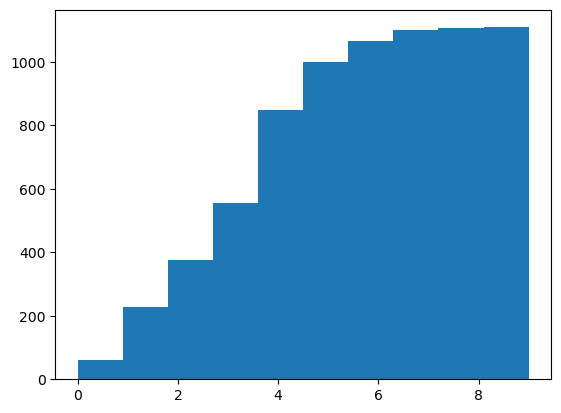

ValueError: only one element tensors can be converted to Python scalars

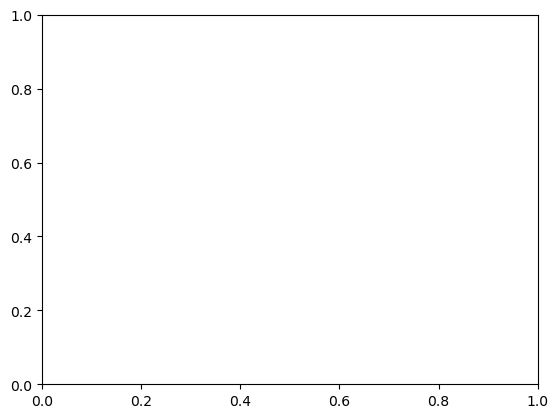

In [57]:
y_list = [item['Y_Label'] for item in data_loader.dataset.data]
# plt.scatter(*zip(*y_list))
# plt.show()
plt.hist(y_list[2][1],bins=10)
plt.show()
plt.hist([y[1] for y in y_list],bins=10)
plt.show()

In [5]:

# build model architecture, then print to console
device, device_ids = prepare_device(config['n_gpu'], config['device_id'])
# print(device)
print('Constructing model...')
model = config.init_obj('arch', module_arch, [data_loader.graphdata for i in range(18)])
logger.info(model)

# prepare for (multi-device) GPU training
# device, device_ids = prepare_device(config['n_gpu'], config['device_id'])

# device = "cpu"
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

# get function handles of loss and metrics
criterion = getattr(module_loss, config['loss'])
metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)
# for state in optimizer.state.values():
# 	for k, v in state.items():
# 		if isinstance(v, torch.Tensor):
# 			state[k] = v.to(device)

Constructing model...
Skill_Evolve_Hetero(
  (criterion): NLLLoss()
  (dyskillhgnn): DySkillHGNN(
    (hgnn): HeteroHGNN(
      (heterognn): HeteroConv(num_relations=3)
    )
    (init_skill_emb): Embedding(11721, 128)
    (conv): ModuleDict(
      (nodeis_parentnode): normal_conv(
        (fc1): Linear(in_features=256, out_features=1, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
      )
      (nodeis_childnode): normal_conv(
        (fc1): Linear(in_features=256, out_features=1, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
      )
      (noderelatenode): normal_conv(
        (fc1): Linear(in_features=256, out_features=1, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
      )
    )
    (conv2): ModuleDict(
      (nodeis_parentnode): normal_conv(
        (fc1): Linear(in_features=256, out_features=1, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
      )
  

In [18]:
# import gc
# # del model 
# # del trainer
# gc.collect()


21

In [6]:

print("Start Training...")
# del trainer
trainer = Trainer(model, criterion, metrics, optimizer,
                  config=config,
                  device=device,
                  data_loader=data_loader,
                  valid_data_loader=valid_data_loader,
                  lr_scheduler=lr_scheduler)

trainer.train()

Start Training...
torch.Size([512, 128])
torch.Size([512, 128])
Train Epoch: 1 [0/88611 (0%)] Loss: 4.613319
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512, 

KeyboardInterrupt: 